In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
data = torch.utils.data.DataLoader(
       torchvision.datasets.MNIST('../data',
       transform=torchvision.transforms.ToTensor(),
       download=True),
       batch_size=128,
       shuffle=True)

In [45]:
class Encoder(nn.Module):
    def __init__(self, hidden_dims, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(28*28, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims)

        self.proj2mu = nn.Linear(hidden_dims, latent_dims)
        self.proj2sigma = nn.Linear(hidden_dims, latent_dims)

        self.N = torch.distributions.Normal(0, 1)

        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1) # (B, 784)
        x = F.relu(self.linear1(x)) # (B, 256)
        x = F.relu(self.linear2(x)) # (B, 256)

        mu =  self.proj2mu(x) # (B, 2)
        sigma = torch.exp(self.proj2sigma(x)) # (B, 2)
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma**2 / 2 + mu**2 / 2 - torch.log(sigma) - 1/2).sum()
        return z
    
class Decoder(nn.Module):
    def __init__(self, hidden_dims, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, 28*28)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))
    
class VAE(nn.Module):
    def __init__(self, hidden_dims, latent_dims):
        super(VAE, self).__init__()
        self.encoder = Encoder(hidden_dims, latent_dims)
        self.decoder = Decoder(hidden_dims, latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

training: 100%|██████████| 469/469 [00:11<00:00, 42.09it/s]


loss:  4044.380615234375


training: 100%|██████████| 469/469 [00:12<00:00, 38.63it/s]


loss:  4043.709228515625


training: 100%|██████████| 469/469 [00:15<00:00, 31.10it/s]


loss:  3793.897705078125


training: 100%|██████████| 469/469 [00:20<00:00, 23.00it/s]


loss:  3808.00634765625


training: 100%|██████████| 469/469 [00:21<00:00, 22.16it/s]

loss:  3848.4794921875


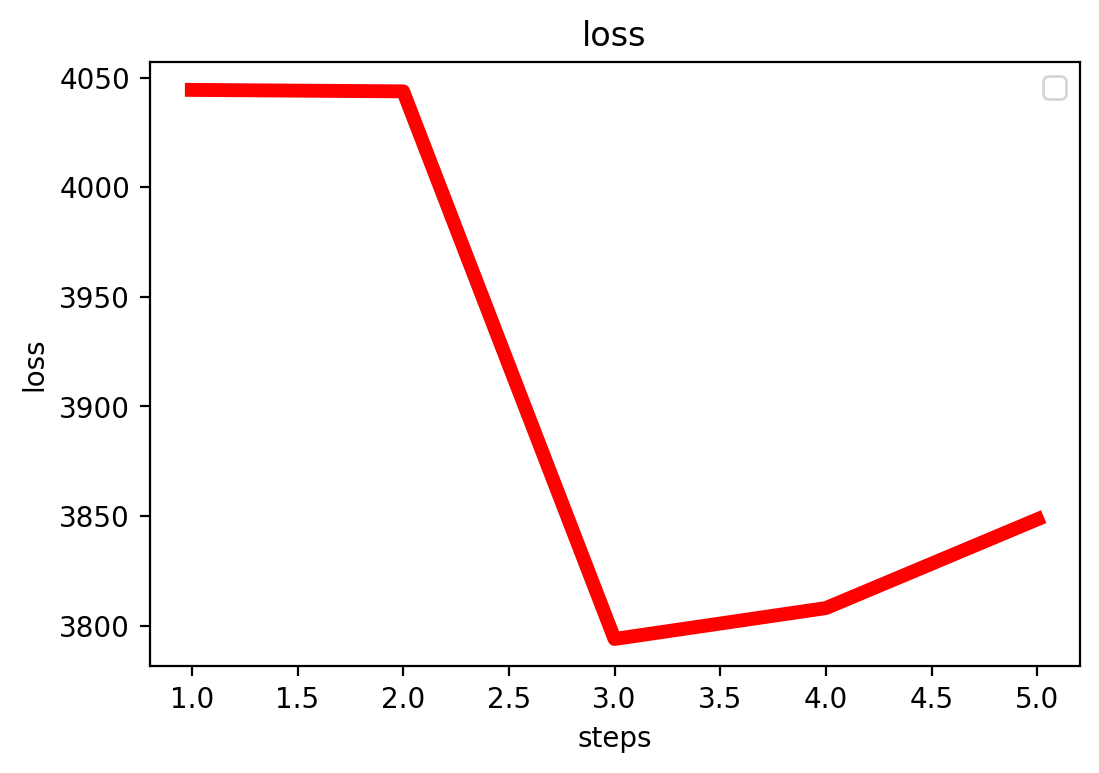

In [47]:
hidden_dims, latent_dims = 512, 2
lr = 0.001
epochs = 5
vae = VAE(hidden_dims, latent_dims)


ep = []
train_loss = []
# train
opt = torch.optim.Adam(vae.parameters(), lr)
for epoch in range(epochs):
    for i, (x, y) in enumerate(tqdm(data, desc='training')):
        opt.zero_grad()
        x_hat = vae(x)
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl
        loss.backward()
        opt.step()
    ep.append(epoch + 1) 
    train_loss.append(loss.item())
    print('loss: ', loss.item())
    

plt.title("loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.legend(["train_loss",
            "val_loss"])
plt.plot(ep, train_loss, 'r', lw=5)


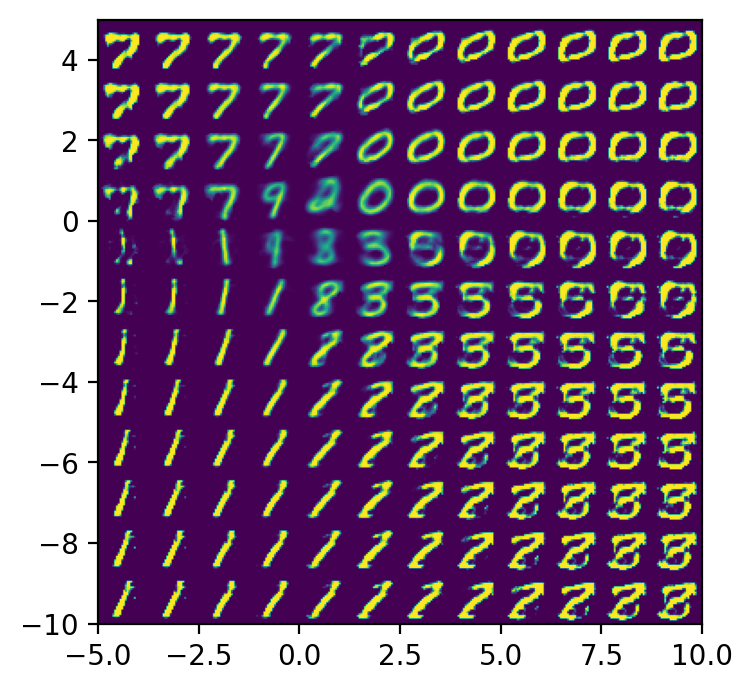

In [ ]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]])
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])
plot_reconstructed(vae)